In [62]:
from google.colab import drive

drive.mount('/content/gdrive')   # google drive를 google colab에 연결. 처음 실행 시, 인증 필요

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [63]:
import os                                               #파일 경로 접근 등에 활용할 때 쓰임
import cv2                                              #컴퓨터비전, 이미지 분석 처리에 활용되는 모듈
from tqdm import tqdm                                   #프로그램의 진행 상황을 가시적으로 볼 수 있는 모듈
import numpy as np                                      #N차원 배열을 처리하기 위한 모듈
import tensorflow as tf               
from sklearn.utils import shuffle         
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [64]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor'] #순서대로 신경교종, 종양 없음, 뇌수막종, 뇌하수체샘종 의미

In [65]:
X_train = []
y_train = []
image_size = 150
dir = "/content/gdrive/My Drive/Colab Notebooks/Brain Tumor Classification (MRI)"
for i in labels:
    folderPath = os.path.join(dir,'Training',i)           #이미지 가져올 폴더 지정
    for j in tqdm(os.listdir(folderPath)):                #tqdm은 진행상황을 가시적으로 보여준다. / folderPath 안의 파일명을 j로 불러온다.
        img = cv2.imread(os.path.join(folderPath,j))      #folderPath의 주소와 파일명을 join하여 cv2 모듈을 활용하여 이미지로 불러온다.
        img = cv2.resize(img,(image_size, image_size))    #이미지 크기를 분석에 용이하게 조정
        X_train.append(img)                               #미리 초기화해둔 X_train에 이미지를, y_train에 라벨(종양 종류)를 append한다.
        y_train.append(i)
        X_train.append(cv2.flip(img, 0))  #상하대칭
        y_train.append(i)
        X_train.append(cv2.flip(img, 1))  #좌우대칭
        y_train.append(i)
        X_train.append(cv2.flip(img, -1)) #상하좌우대칭
        y_train.append(i) 

for i in labels:
    folderPath = os.path.join(dir,'Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        X_train.append(cv2.flip(img, 0))  #상하대칭
        y_train.append(i)
        X_train.append(cv2.flip(img, 1))  #좌우대칭
        y_train.append(i)
        X_train.append(cv2.flip(img, -1)) #상하좌우대칭
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 75.33it/s]


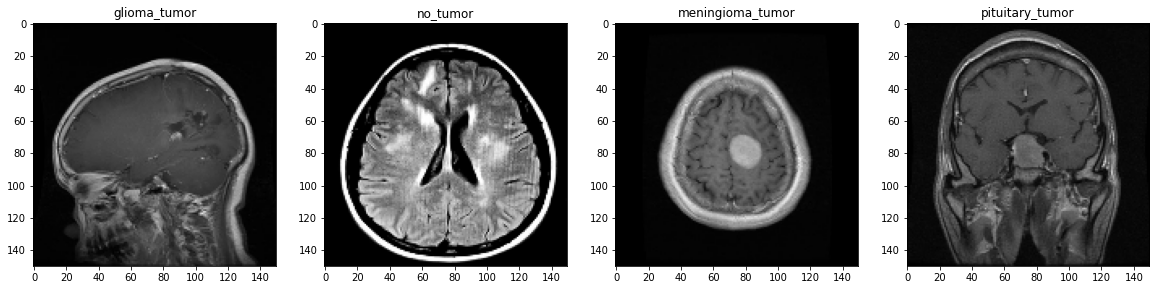

In [66]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))

for i in labels:                              #라벨 별로 이미지를 하나씩만 불러오는 반복문
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])          #이미지를 k번째 subplot에 표현
            ax[k].set_title(y_train[j])       #라벨도 k번째 subplot에 표현
            # ax[k].axis('off')
            k+=1
            break
        j+=1

In [67]:
X_train, y_train = shuffle(X_train, y_train, random_state=17)                                       #트레이닝셋을 사이킷런의 셔플 기능으로 섞어준다.

In [68]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=23)    #트레이닝셋의 10%비율을 따로 나눠 테스트셋을 지정해준다. 

In [69]:
#라벨 이름으로 지정되어 있던 y값들을 원핫인코딩 형식으로 바꿔준다.
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

"""
[1., 0., 0., 0.]  : 'glioma_tumor'
[0., 1., 0., 0.]  : 'no_tumor'
[0., 0., 1., 0.]  : 'meningioma_tumor'
[0., 0., 0., 1.]  : 'pituitary_tumor'
"""

"\n[1., 0., 0., 0.]  : 'glioma_tumor'\n[0., 1., 0., 0.]  : 'no_tumor'\n[0., 0., 1., 0.]  : 'meningioma_tumor'\n[0., 0., 0., 1.]  : 'pituitary_tumor'\n"

In [70]:
effnet = tf.keras.applications.efficientnet.EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size, 3))

In [71]:
model = effnet.output                                           #이미지넷으로 학습한 EfficientNetB0 가중치 가져옴
model = tf.keras.layers.GlobalAveragePooling2D()(model)         #평균풀링층
model = tf.keras.layers.Dropout(rate=0.5)(model)                #학습 과정에서 드랍아웃 50%
model = tf.keras.layers.Dense(4, activation='softmax')(model)           
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

"""
Softmax(소프트맥스)는 입력받은 값을 출력으로 0~1사이의 값으로 모두 정규화하며, 출력 값들의 총합은 항상 1이 되는 특성을 가진 함수이다.
분류하고 싶은 클래스의 수 만큼 출력으로 구성한다.
가장 큰 출력 값을 부여받은 클래스의 확률이 가장 높은 것이다.
"""

In [72]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 150, 150, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 150, 150, 3)  7          ['rescaling_3[0][0]']            
 )                                                                                                
                                                                                            

In [73]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [74]:
# 데이터 훈련하기
history = model.fit(
    X_train, y_train,
    batch_size=200,  #(batch_size)개에 한 번씩 업데이터 실행
    epochs=50,       #훈련 데이터셋을 총 (epochs)회 반복 실험. 단, 조기중지될 수 있음
    validation_split=0.15,  
      #validation data 분할 비율. 즉, X_train에 속한 데이터 개수의 15%를 validation용으로 분할
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)],  
      #'val_accuracy'를 monitor하여 감소하면 한 번 더(1) 참고 조기중지
    verbose=1)  #전 과정을 화면에 출력(1) 또는 미출력(0) 모드



# 테스트 데이터로 평가하기
score = model.evaluate(X_test, y_test)
print('test_loss: ', score[0])
print('test_acc: ', score[1])

Epoch 1/50
50/50 [==============================] - 104s 2s/step - loss: 0.2906 - accuracy: 0.8927 - val_loss: 0.9452 - val_accuracy: 0.7907
Epoch 2/50
50/50 [==============================] - 85s 2s/step - loss: 0.0581 - accuracy: 0.9797 - val_loss: 0.2349 - val_accuracy: 0.9251
Epoch 3/50
50/50 [==============================] - 85s 2s/step - loss: 0.0246 - accuracy: 0.9918 - val_loss: 0.0914 - val_accuracy: 0.9705
Epoch 4/50
50/50 [==============================] - 85s 2s/step - loss: 0.0157 - accuracy: 0.9954 - val_loss: 0.0680 - val_accuracy: 0.9841
Epoch 5/50
50/50 [==============================] - 85s 2s/step - loss: 0.0243 - accuracy: 0.9912 - val_loss: 0.0558 - val_accuracy: 0.9847
Epoch 6/50
50/50 [==============================] - 85s 2s/step - loss: 0.0239 - accuracy: 0.9917 - val_loss: 0.0260 - val_accuracy: 0.9898
Epoch 7/50
50/50 [==============================] - 85s 2s/step - loss: 0.0165 - accuracy: 0.9952 - val_loss: 0.0941 - val_accuracy: 0.9716
Epoch 8/50
50/50 [=

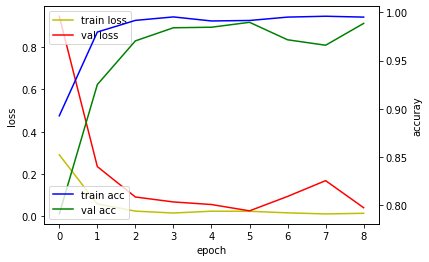

In [75]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()